# Элементарные методы анализа временных рядов

## Домашнее задание

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

# Дополнительно почитать

[Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)

[Holt-Winters Forecasting for Dummies (or Developers)](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)

In [1]:
import pandas as pd
import numpy as np

In [2]:
sales_of_company_x = pd.read_csv("../1. Знакомство с временными рядами/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../1. Знакомство с временными рядами/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../1. Знакомство с временными рядами/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../1. Знакомство с временными рядами/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../1. Знакомство с временными рядами/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../1. Знакомство с временными рядами/Series/daily-total-female-births-in-cal.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

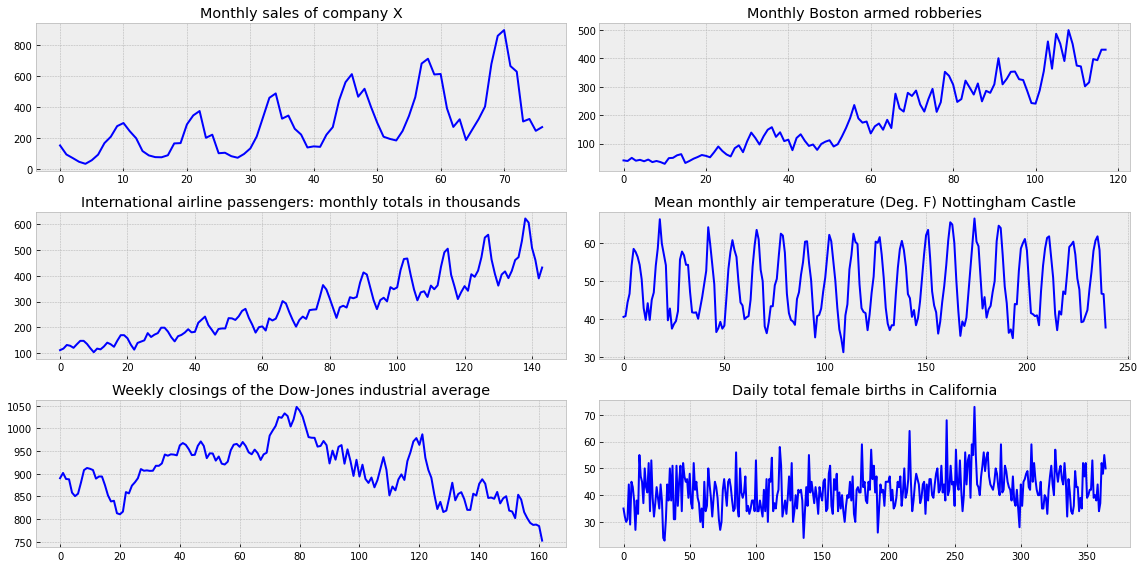

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [6]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

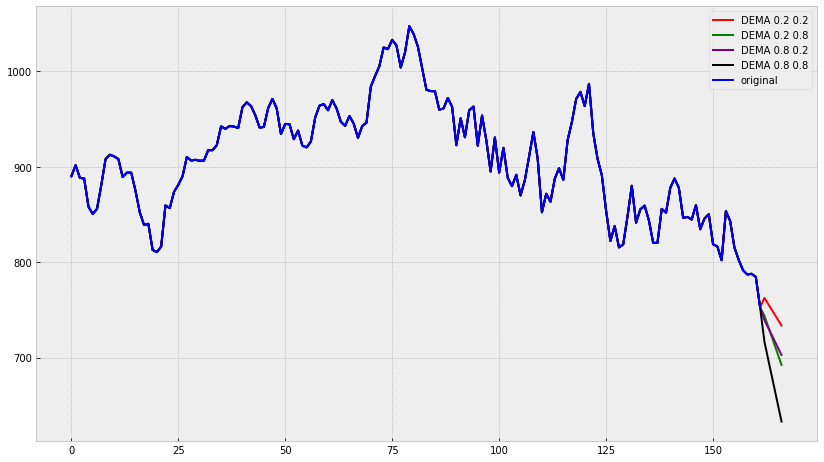

In [7]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
series = all_series['Weekly closings of the Dow-Jones industrial average']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(series, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [8]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [9]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [10]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [11]:
def plot_tema(
    alpha,
    beta,
    gamma,
    ser=sales_of_company_x["Count"],
    ser_to_plot=sales_of_company_x["Count"],
    n_preds=24,
    slen=12,
    ser_title=None
):
    tema = triple_exponential_smoothing(ser, slen, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        
        title = "alpha={}, beta={}, gamma={}".format(alpha, beta, gamma)
        if ser_title:
            title = "{}\n{}".format(ser_title, title)
        plt.title(title)
        plt.legend()

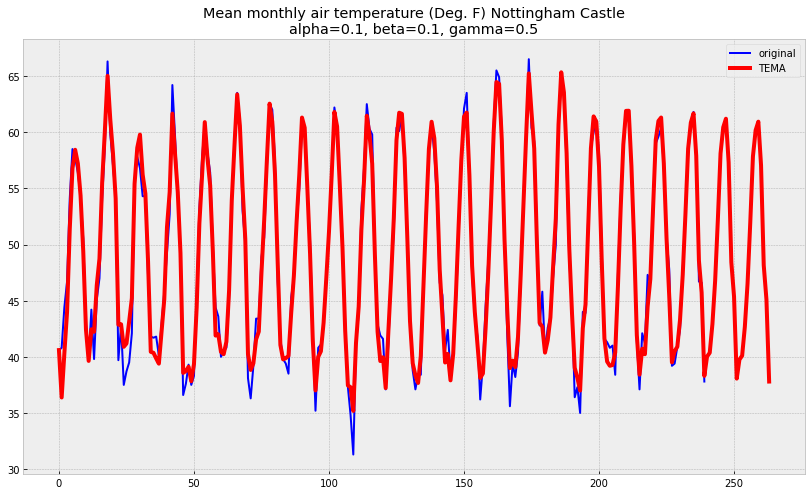

In [12]:
ser_title = 'Mean monthly air temperature (Deg. F) Nottingham Castle'
ser = all_series[ser_title]
plot_tema(0.1, 0.1, 0.5, ser=ser, ser_title=ser_title)